# Posterior Predictive Distribution for a Coin Toss (PyMC3)

In this notebook we build a simple Bayesian model for a coin toss and plot the posterior predictive distribution for the number of heads in a future set of tosses.


In [2]:
# Imports (comments in English as required)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import PyMC3; if not available, fall back to PyMC v4
try:
    import pymc3 as pm  # classic PyMC3 API
    PYMCMODE = 'pymc3'
except Exception:
    import pymc as pm    # PyMC v4+ API
    import arviz as az
    import xarray as xr
    PYMCMODE = 'pymc'

# Plotting style
sns.set(style="whitegrid")
RNG_SEED = 42
np.random.seed(RNG_SEED)


## Observed data
Assume we observed `k_obs` heads in `n_obs` tosses of the same coin.


In [3]:
# Observed number of heads (k_obs) out of total tosses (n_obs)
n_obs = 10
k_obs = 7
n_new = 10  # number of tosses we want to predict for in the future
k_obs, n_obs, n_new


(7, 10, 10)

## Model definition
We use a Beta(1, 1) prior for the coin's probability of heads `theta`.
The likelihood for the observed heads is Binomial(`n_obs`, `theta`).
We also define a predictive node `y_new` for `n_new` future tosses.


In [6]:
# Build and sample the model
with pm.Model() as model:
    # Prior over coin bias (theta)
    theta = pm.Beta('theta', alpha=1.0, beta=1.0)

    # Observed data: number of heads in n_obs tosses
    y = pm.Binomial('y', n=n_obs, p=theta, observed=k_obs)

    # Predictive node for future experiment with n_new tosses
    y_new = pm.Binomial('y_new', n=n_new, p=theta)

    # MCMC sampling from the posterior
    if PYMCMODE == 'pymc3':
        trace = pm.sample(
            draws=2000, tune=1000, chains=2, cores=1, target_accept=0.9,
            random_seed=RNG_SEED, return_inferencedata=False
        )
        # Posterior predictive sampling for y_new
        ppc = pm.sample_posterior_predictive(trace, var_names=['y_new'], random_seed=RNG_SEED)
    else:
        idata = pm.sample(
            draws=2000, tune=1000, chains=2, cores=1, target_accept=0.9,
            random_seed=RNG_SEED
        )
        # Posterior predictive sampling for y_new (idata-aware)
        ppc = pm.sample_posterior_predictive(idata, var_names=['y_new'], random_seed=RNG_SEED)


Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [theta]
>Metropolis: [y_new]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_new]


Output()

## Posterior predictive distribution (histogram)
We plot the histogram of sampled `k` (number of heads) for the future `n_new` tosses.


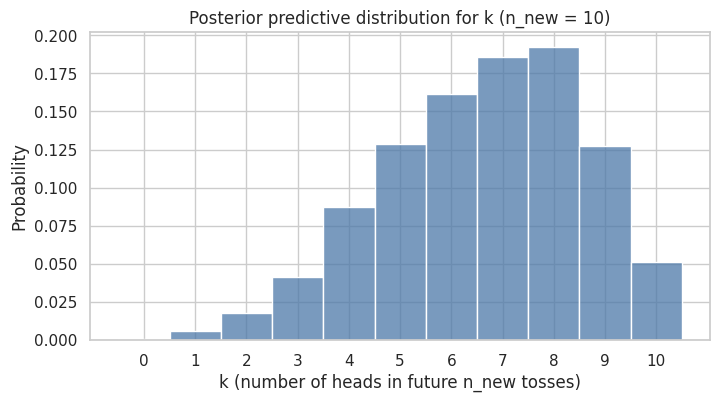

In [7]:
# Extract samples of k for the future experiment
if PYMCMODE == 'pymc3':
    k_samples = ppc['y_new'].ravel()
else:
    # ppc is InferenceData; extract from posterior_predictive group
    k_samples = np.asarray(ppc.posterior_predictive['y_new']).ravel()

# Discrete bins centered on integers 0..n_new
bins = np.arange(-0.5, n_new + 1.5, 1)
plt.figure(figsize=(8, 4))
sns.histplot(k_samples, bins=bins, stat='probability', color='#4c78a8', edgecolor='white')
plt.xticks(range(0, n_new + 1))
plt.xlabel('k (number of heads in future n_new tosses)')
plt.ylabel('Probability')
plt.title('Posterior predictive distribution for k (n_new = %d)' % n_new)
plt.show()


### Optional: posterior over theta
For reference, we can also visualize the posterior distribution of the coin bias `theta`.


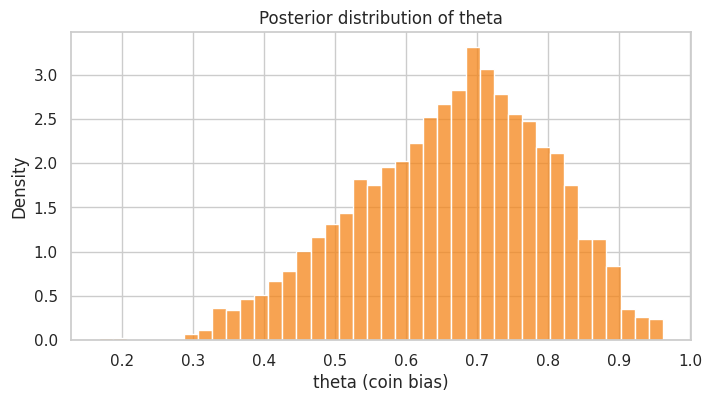

In [8]:
# Plot posterior samples of theta
if PYMCMODE == 'pymc3':
    thetas = pm.traceplot  # placeholder to avoid NameError if trace missing
    # In PyMC3, use trace from above scope
    try:
        thetas = trace.get_values('theta')
    except NameError:
        thetas = None
else:
    try:
        thetas = np.asarray(idata.posterior['theta']).ravel()
    except NameError:
        thetas = None

if thetas is not None:
    plt.figure(figsize=(8, 4))
    sns.histplot(thetas, bins=40, stat='density', color='#f58518', edgecolor='white')
    plt.xlabel('theta (coin bias)')
    plt.ylabel('Density')
    plt.title('Posterior distribution of theta')
    plt.show()
else:
    print("Posterior samples for theta are not available.")
